In [4]:
import pandas as pd
import numpy as np 
import warnings
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from dateutil.relativedelta import relativedelta

warnings.filterwarnings("ignore")


c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [5]:
ticker = '^BVSP'
inicio = '2023-01-01'
#pega um mês antes da data passada
inicio_anterior = pd.to_datetime('2023-01-01')
inicio_anterior = inicio_anterior - relativedelta(months=1)
fim = '2024-02-01'

#carrega informacoes do IBovespa
df = yf.download(ticker, start=inicio_anterior, end=fim)

#seleciona somente a coluna de fechamento
df_close = df[['Close']]

df_close.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2022-12-01,110926.0
2022-12-02,111924.0
2022-12-05,109401.0
2022-12-06,109533.0
2022-12-07,109361.0


In [6]:
#Criar datas faltantes repetindo o valor ultima data conhecida
df_close_resample = df_close
df_close_resample = df_close_resample.resample('D').ffill()
df_close_resample = df_close_resample[df_close_resample.index >= inicio]

df_close_resample['id'] = range(1, len(df_close_resample) + 1)
df_close_resample.reset_index(inplace=True)
df_close_resample = df_close_resample.set_index('id')

df_close_resample['Date'] = pd.to_datetime(df_close_resample['Date'], format='%Y-%m-%d')

#renomear colunas do dataframe
df_close_resample.columns = ['ds', 'y']
df_close_resample['unique_id'] = 'IBOV'


df_close_resample.head(20)

,ds,y,unique_id
id,,,
1,2023-01-01,110031.0,IBOV
2,2023-01-02,106376.0,IBOV
3,2023-01-03,104166.0,IBOV
4,2023-01-04,105334.0,IBOV
5,2023-01-05,107518.0,IBOV
6,2023-01-06,108836.0,IBOV
7,2023-01-07,108836.0,IBOV
8,2023-01-08,108836.0,IBOV
9,2023-01-09,109227.0,IBOV


In [7]:
#Criar datas faltantes com nulo
df_close_interpolate = df_close.resample('D').asfreq()

#Criar datas faltantes com valores interpolados
df_close_interpolate = df_close_interpolate.interpolate()
df_close_interpolate = df_close_interpolate[df_close_interpolate.index >= inicio]

df_close_interpolate['id'] = range(1, len(df_close_interpolate) + 1)
df_close_interpolate.reset_index(inplace=True)
df_close_interpolate = df_close_interpolate.set_index('id')

df_close_interpolate['Date'] = pd.to_datetime(df_close_interpolate['Date'], format='%Y-%m-%d')

#renomear colunas do dataframe
df_close_interpolate.columns = ['ds', 'y']
df_close_interpolate['unique_id'] = 'IBOV'

df_close_interpolate.head(20)

,ds,y,unique_id
id,,,
1,2023-01-01,107289.750000,IBOV
2,2023-01-02,106376.000000,IBOV
3,2023-01-03,104166.000000,IBOV
4,2023-01-04,105334.000000,IBOV
5,2023-01-05,107518.000000,IBOV
6,2023-01-06,108836.000000,IBOV
7,2023-01-07,108966.333333,IBOV
8,2023-01-08,109096.666667,IBOV
9,2023-01-09,109227.000000,IBOV


In [8]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA


In [9]:
#Separar dados de treino e validação resample
train_resample = df_close_resample[df_close_resample['ds'] < '2024-01-01']
test_resample = df_close_resample[df_close_resample['ds'] >= '2024-01-01']
h_resample = len(test_resample)


In [10]:
#Separar dados de treino e validação interpolados 
train_interpolate = df_close_interpolate[df_close_interpolate['ds'] < '2024-01-01']
test_interpolate = df_close_interpolate[df_close_interpolate['ds'] >= '2024-01-01']
h_interpolate = len(test_interpolate)

In [11]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [12]:
#Usar modelo naive sem decomposição - resample
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(train_resample)

forecast_df = model.predict(h=h_resample, level=[90])
forecast_df = forecast_df.reset_index().merge(test_resample, on=['ds','unique_id'], how='left')
    
wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")


WMAPE: 3.31%


In [13]:
#Usar modelo naive sem decomposição - interpolate
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(train_interpolate)

forecast_df = model.predict(h=h_interpolate, level=[90])
forecast_df = forecast_df.reset_index().merge(test_interpolate, on=['ds','unique_id'], how='left')
    
wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")


WMAPE: 2.67%


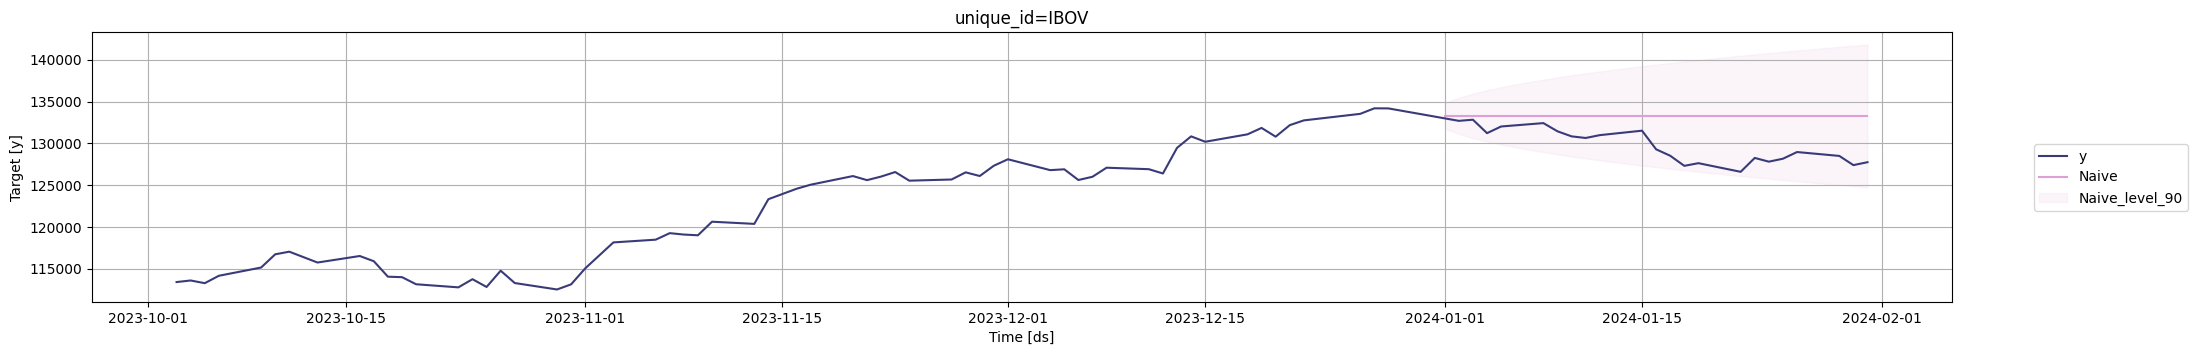

In [14]:
model.plot(train_interpolate, forecast_df, level=[90], unique_ids=['IBOV'],engine ='matplotlib', max_insample_length=90)

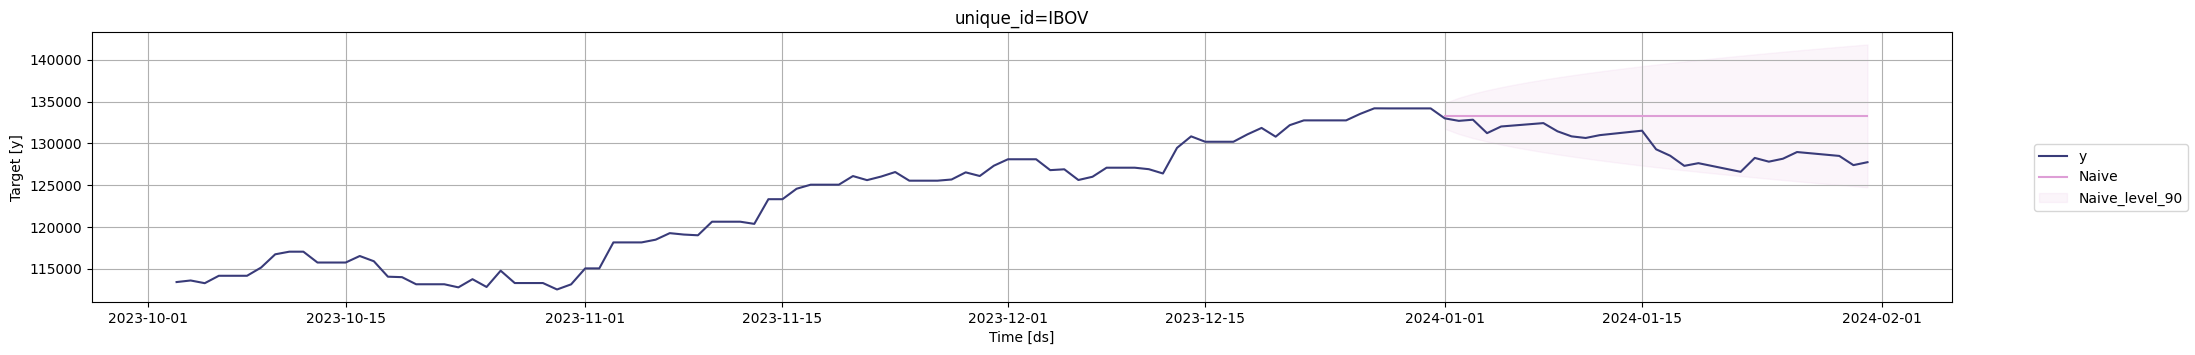

In [15]:
model.plot(train_resample, forecast_df, level=[90], unique_ids=['IBOV'],engine ='matplotlib', max_insample_length=90)

In [18]:
#Usar modelo SeasonalNaive sem decomposição - resample
model = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model.fit(train_resample)

forecast_df2 = model.predict(h=h_resample, level=[90])
forecast_df2 = forecast_df2.reset_index().merge(test_resample, on=['ds','unique_id'], how='left')
    
wmape1 = wmape(forecast_df2['y'].values, forecast_df2['SeasonalNaive'].values)
print(f"WMAPE: {wmape1:.2%}")

WMAPE: 3.13%


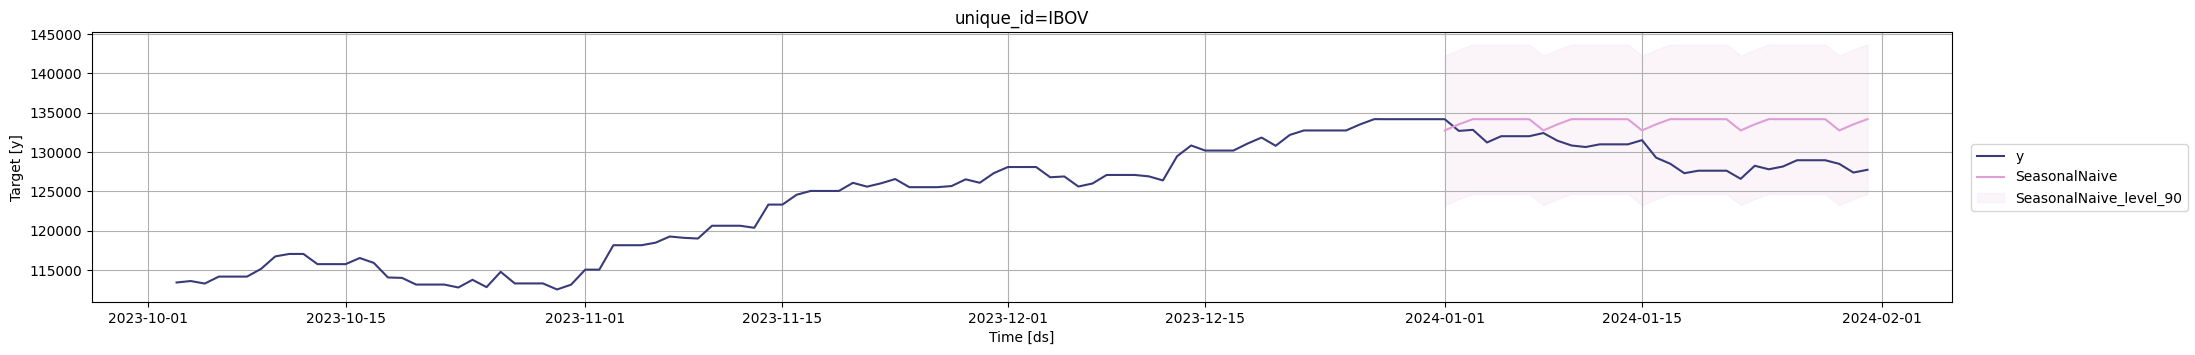

In [19]:
model.plot(train_resample, forecast_df2, level=[90], unique_ids=['IBOV'], engine='matplotlib', max_insample_length=90)

In [ ]:
df_decompose = seasonal_decompose(df_close, period=30)


<Axes: xlabel='Date'>

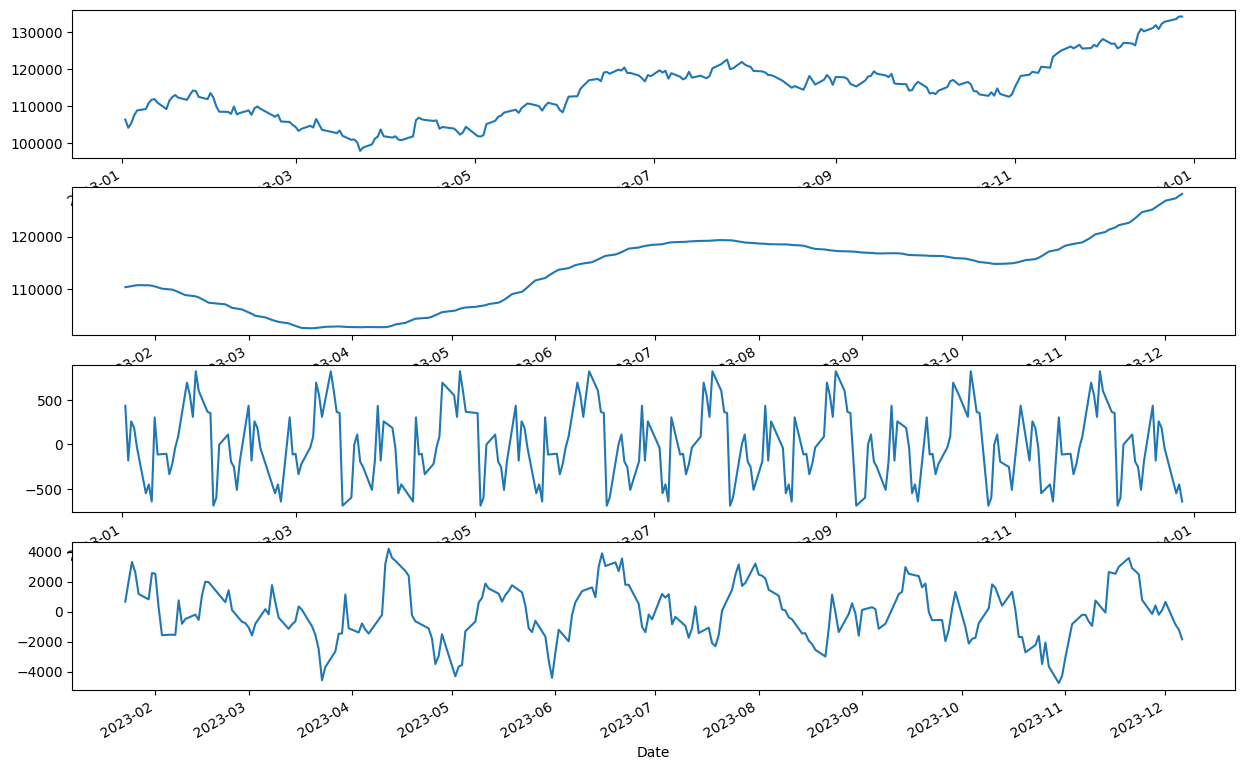

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

df_decompose.observed.plot(ax=ax1)
df_decompose.trend.plot(ax=ax2)
df_decompose.seasonal.plot(ax=ax3)
df_decompose.resid.plot(ax=ax4)